# **ENDG 511 Lab 3 Assignment: Model Pruning and Quantization**

This colab notebook provides code and a framework for ***Lab 3***. You can work out your solutions here.


## Goals

In this lab, you will be introduced to different model optimization methods using TensorFlow and Keras, and you will learn how to use them to create efficient deep learning models. The goals of this lab are:

- Understand the basics of pruning and quantization.
- Apply pruning and quantization to an MNIST model.
- Understand and use TFLite.
- Evaluate models in terms of accuracy, size and inference time.
- Understand how different pruning and quantization parameters can impact accuracy, size and inference time.
- Apply collaborative optimization by combining pruning and quantization.

## Layout
This lab is split into **three** parts.
- **Part 1**: Apply pruning to an MNIST model and evaluate the pruned model.
- **Part 2**: Apply post-training quantization and evaluate the quantized model.
- **Part 3**: Combine pruning and post-training quantization and evaluate the final model.

## How to submit the Assignment

- You are required to sumbmit the completed python notebook and a **pdf version** of it in a Dropbox folder on D2L.
- This is an individual assignment, and all the assignements must be submitted individually.
- This assignment can be completed directly on Google Colab, but you are free to choose any other computing resource.
-  Lab sessions will be held to go over the main concepts and help you with the assignment.

- **Due Date: 17th February 2023**

# **Part 1**: Pruning

This part of the lab demonstrates applying pruning to a neural network to reduce size and inference while maintaining a similar accuracy to the original neural network. At a high level, the steps required to prune and evaluate a model are as follows:

- Build and train the dense baseline
- Prune model
- Fine-tune pruned model
- Evaluate the model

There are different types of pruning techniques, the technique demonstrated in this lab is magnitude-based weight pruning (also referred to as unstructured pruning). Magnitude-based weight pruning gradually zeroes out model weights based on their importance during the training process to achieve model sparsity. Sparse models are easier to compress, and we can skip the zeroes during inference for latency improvements. The image below can help you visualize pruning:

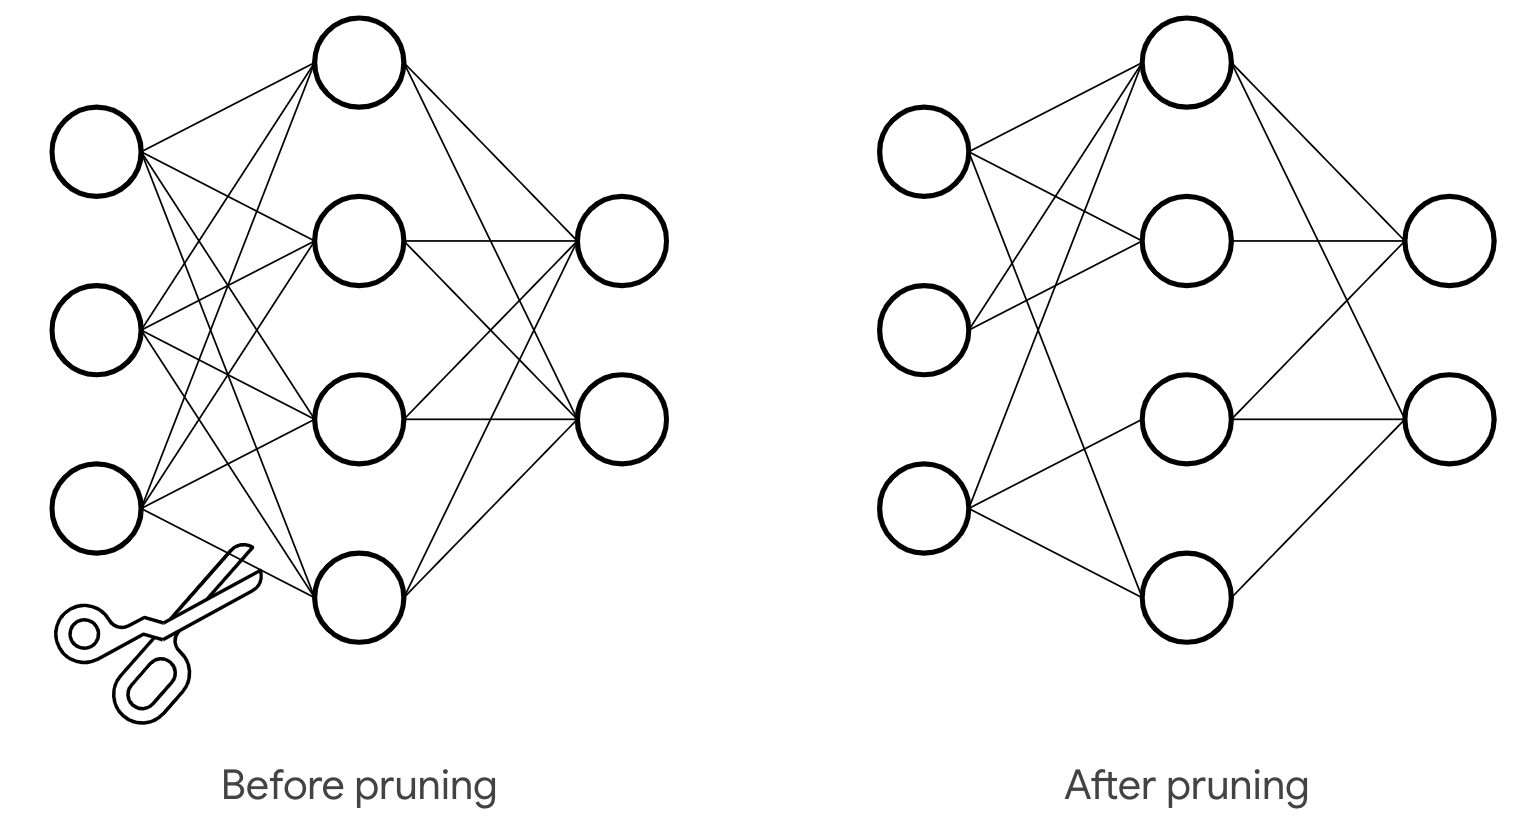

### Import and install all required modules

In [ ]:
!pip install -q tensorflow-model-optimization

import tempfile
import os
import time

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow_model_optimization as tfmot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 3.5 MB/s eta 0:00:00


### Build and Train a neural network for MNIST without pruning

Similar to the examples presented in Lab1 we will build and train a neural network for the MNIST dataset without any model optimization. This will be our base model for the remainder of this lab. We also save the model before training.


In [ ]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 and 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

# Define the model architecture.
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

# Save untrained model
model.save('untrained_base_model.h5')

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
model.fit(
  train_images,
  train_labels,
  epochs=5,
  validation_split=0.1,
)

11490434/11490434 [==============================] - 2s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/5
1688/1688 [==============================] - 16s 7ms/step - loss: 0.3160 - accuracy: 0.9082 - val_loss: 0.1320 - val_accuracy: 0.9645
Epoch 2/5
1688/1688 [==============================] - 12s 7ms/step - loss: 0.1513 - accuracy: 0.9554 - val_loss: 0.0947 - val_accuracy: 0.9737
Epoch 3/5
1688/1688 [==============================] - 9s 5ms/step - loss: 0.1136 - accuracy: 0.9664 - val_loss: 0.0815 - val_accuracy: 0.9750
Epoch 4/5
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0929 - accuracy: 0.9709 - val_loss: 0.0722 - val_accuracy: 0.9783
Epoch 5/5
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0791 - accuracy: 0.9756 - val_loss: 0.0732 - val_accuracy: 0.9768


Let's display the architecture of our model:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Save model
Let us save the trained model so that we can evaluate at a later stage.

In [ ]:
# Save your trained model
model.save('trained_base_model.h5')

### Prune the dense model
We will create a pruned model from our original model. We will force the model to have 50% sparsity (50% of the weights are zeroed out). Finally we recompile our new pruned model.

Note: ConstantSparsity performs "one-shot" magnitude based pruning of all the layers. There are more advanced techniques but this is the simplest one. The total number of parameters increases because tensorflow adds a "pruning wrapper" to all parameters, this gets stripped at a later stage.

In [ ]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
## Print weights before and after

# Define model for pruning. The 0.5 is the target sparsity (50%)
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=0, end_step=0, frequency=1)
}

pruned_model = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
pruned_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

pruned_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_flatte  (None, 784)               1         
 n (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense   (None, 128)               200834    
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_dropou  (None, 128)               1         
 t (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense_  (None, 10)                2572      
 1 (PruneLowMagnitude)                                           
                                                                 
Total params: 203408 (794.58 KB)
Trainable params: 10177

### Fine-tune pruned model
Next, we have to fine-tune our pruned model by retraining for a suitable number of epochs.
Note: tfmot.sparsity.keras.UpdatePruningStep is required as a callback during training.

In [ ]:
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
]

pruned_model.fit(train_images, train_labels, epochs=2, validation_split=0.1,
                  callbacks=callbacks)

Epoch 1/2
1688/1688 [==============================] - 11s 5ms/step - loss: 0.0224 - accuracy: 0.9921 - val_loss: 0.0962 - val_accuracy: 0.9827
Epoch 2/2
1688/1688 [==============================] - 10s 6ms/step - loss: 0.0216 - accuracy: 0.9924 - val_loss: 0.0918 - val_accuracy: 0.9815


### Apply strip pruning

strip_pruning is necessary since it removes every tf.Variable that pruning only needs during training, which would otherwise add to the final model size. It strips the pruning wrapper, It is also needed when converting to a TFLite model.

In [ ]:
stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)
stripped_pruned_model.save('stripped_pruned_model.h5')

### Confirm that pruning was correctly applied

In [ ]:
def print_model_weights_sparsity(model):

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )
print_model_weights_sparsity(stripped_pruned_model)

dense/kernel:0: 13.77% sparsity  (13819/100352)
dense_1/kernel:0: 0.78% sparsity  (10/1280)


### Evaluate the model
Finally, we compare the pruned model to the base model. We can see that the accuracy and inference time is comparable, however, the pruned model is much smaller in size.

Note: Pruning is capable of improving inference time significantly, however, additional libraries and modifications are needed to see inference improvements as a result of pruning (Pruning inference improvements is very hardware specific!). If you are curious you can read this paper which explains how sparse models can be used to accelerate inference (https://arxiv.org/pdf/1911.09723.pdf)

In [ ]:
# Evaluate prediction accuracy
model = tf.keras.models.load_model('trained_base_model.h5')
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=0)
test_loss_pruned_50, test_acc_pruned_50 = pruned_model.evaluate(test_images,  test_labels, verbose=0)


# Evaluate Model Size
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)


# Evaluate Inference Time
startTime = time.time()
prediction = model.predict(test_images)
executionTime = (time.time() - startTime)/len(test_images)

startTime = time.time()
prediction = pruned_model.predict(test_images)
executionTimePruned50 = (time.time() - startTime)/len(test_images)

base_model_size = get_gzipped_model_size('untrained_base_model.h5')
## Print without stripping
pruned_model_size = get_gzipped_model_size('stripped_pruned_model.h5')

# Print
print('\nBase Model Accuracy:', test_acc*100, '%')
print("Base Model Size: %.2f bytes" % (base_model_size))
print("Base Inference Time is", executionTime, "s")

print('\nPruned Model Accuracy:', test_acc_pruned_50*100, '%')
print("Pruned Model Size: %.2f bytes" % (pruned_model_size))
print("Pruned Inference Time is", executionTimePruned50, "s")

313/313 [==============================] - 1s 2ms/step

Base Model Accuracy: 97.94999957084656 %
Base Model Size: 374842.00 bytes
Base Inference Time is 8.691060543060302e-05 s

Pruned Model Accuracy: 97.94999957084656 %
Pruned Model Size: 234896.00 bytes
Pruned Inference Time is 8.170764446258545e-05 s


### Excercies: (1.5 points)


Question 1: Load the trained base model (unpruned). Prune the model with a target sparsity of 90%. Evaluate the model in terms of accuracy, model size and inference time. **(0.5 points)**

In [ ]:
# Loading the trained base model (unpruned)

unpruned_model = tf.keras.models.load_model('trained_base_model.h5')

In [ ]:
# Pruning the model with a target sparsity of 90%
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
## Print weights before and after

# Define model for pruning.
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.9, begin_step=0, frequency=100)
}

pruned_model_90 = prune_low_magnitude(unpruned_model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
pruned_model_90.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

pruned_model_90.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_flatten  (None, 784)              1         
 _4 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_dense_8  (None, 128)              200834    
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_dropout  (None, 128)              1         
 _4 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_dense_9  (None, 10)               2572      
  (PruneLowMagnitude)                                            
                                                                 
Total params: 203,408
Trainable params: 101,770
Non-tr

In [ ]:
# Fine tune pruned model
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
]

pruned_model_90.fit(train_images, train_labels, epochs=2, validation_split=0.1,
                  callbacks=callbacks)

Epoch 1/2
1688/1688 [==============================] - 10s 5ms/step - loss: 0.4891 - accuracy: 0.8496 - val_loss: 0.1862 - val_accuracy: 0.9488
Epoch 2/2
1688/1688 [==============================] - 8s 5ms/step - loss: 0.2917 - accuracy: 0.9123 - val_loss: 0.1528 - val_accuracy: 0.9563


In [ ]:
# Applying strip pruning
stripped_pruned_model_90 = tfmot.sparsity.keras.strip_pruning(pruned_model_90)
stripped_pruned_model_90.save('stripped_pruned_model_90.h5')

In [ ]:
# Confirming that pruning was applied correctly
print_model_weights_sparsity(stripped_pruned_model_90)

dense_8/kernel:0: 90.00% sparsity  (90317/100352)
dense_9/kernel:0: 90.00% sparsity  (1152/1280)


In [ ]:
# Evaluate prediction accuracy of newly pruned model
test_loss, test_acc = unpruned_model.evaluate(test_images,  test_labels, verbose=0)
test_loss_pruned_90, test_acc_pruned_90 = pruned_model_90.evaluate(test_images,  test_labels, verbose=0)

# Evaluate Inference Time of newly pruned model (90%)
startTime = time.time()
prediction = unpruned_model.predict(test_images)
executionTime = (time.time() - startTime)/len(test_images)

startTime = time.time()
prediction = pruned_model_90.predict(test_images)
executionTimePruned90 = (time.time() - startTime)/len(test_images)

base_model_size = get_gzipped_model_size('untrained_base_model.h5')
## Print without stripping newly pruned model
pruned_90_model_size = get_gzipped_model_size('stripped_pruned_model_90.h5')

# Print
print('\nBase Model Accuracy:', test_acc*100, '%')
print("Base Model Size: %.2f bytes" % (base_model_size))
print("Base Inference Time is", executionTime, "s")

print('\nPruned Model Accuracy:', test_acc_pruned_90*100, '%')
print("Pruned Model Size: %.2f bytes" % (pruned_90_model_size))
print("Pruned Inference Time is", executionTimePruned90, "s")

313/313 [==============================] - 1s 2ms/step

Base Model Accuracy: 94.9899971485138 %
Base Model Size: 374936.00 bytes
Base Inference Time is 6.704890727996826e-05 s

Pruned Model Accuracy: 94.9899971485138 %
Pruned Model Size: 79955.00 bytes
Pruned Inference Time is 7.490417957305909e-05 s


Question 2: Load the trained base model (unpruned). Prune the model with a target sparsity of 10%. Evaluate the model in terms of accuracy, model size and inference time. **(0.5 points)**

In [ ]:
# Loading the trained base model (unpruned)

unpruned_model = tf.keras.models.load_model('trained_base_model.h5')

In [ ]:
# Pruning the model with a target sparsity of 10%
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
## Print weights before and after

# Define model for pruning.
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.1, begin_step=0, frequency=100)
}

pruned_model_10 = prune_low_magnitude(unpruned_model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
pruned_model_10.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

pruned_model_10.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_flatten  (None, 784)              1         
 _4 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_dense_8  (None, 128)              200834    
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_dropout  (None, 128)              1         
 _4 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_dense_9  (None, 10)               2572      
  (PruneLowMagnitude)                                            
                                                                 
Total params: 203,408
Trainable params: 101,770
Non-tr

In [ ]:
# Fine tune pruned model
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
]

pruned_model_10.fit(train_images, train_labels, epochs=2, validation_split=0.1,
                  callbacks=callbacks)

Epoch 1/2
1688/1688 [==============================] - 10s 5ms/step - loss: 0.0662 - accuracy: 0.9795 - val_loss: 0.0667 - val_accuracy: 0.9822
Epoch 2/2
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0581 - accuracy: 0.9808 - val_loss: 0.0719 - val_accuracy: 0.9793


In [ ]:
# Applying strip pruning
stripped_pruned_model_10 = tfmot.sparsity.keras.strip_pruning(pruned_model_10)
stripped_pruned_model_10.save('stripped_pruned_model_10.h5')

In [ ]:
# Confirming that pruning was applied correctly
print_model_weights_sparsity(stripped_pruned_model_10)

dense_8/kernel:0: 10.00% sparsity  (10035/100352)
dense_9/kernel:0: 10.00% sparsity  (128/1280)


In [ ]:
# Evaluate prediction accuracy of newly pruned model
test_loss, test_acc = unpruned_model.evaluate(test_images,  test_labels, verbose=0)
test_loss_pruned_10, test_acc_pruned_10 = pruned_model_10.evaluate(test_images,  test_labels, verbose=0)

# Evaluate Inference Time of newly pruned model (10%)
startTime = time.time()
prediction = unpruned_model.predict(test_images)
executionTime = (time.time() - startTime)/len(test_images)

startTime = time.time()
prediction = pruned_model_10.predict(test_images)
executionTimePruned10 = (time.time() - startTime)/len(test_images)

base_model_size = get_gzipped_model_size('untrained_base_model.h5')
## Print without stripping newly pruned model
pruned_10_model_size = get_gzipped_model_size('stripped_pruned_model_10.h5')

# Print
print('\nBase Model Accuracy:', test_acc*100, '%')
print("Base Model Size: %.2f bytes" % (base_model_size))
print("Base Inference Time is", executionTime, "s")

print('\nPruned Model Accuracy:', test_acc_pruned_10*100, '%')
print("Pruned Model Size: %.2f bytes" % (pruned_10_model_size))
print("Pruned Inference Time is", executionTimePruned10, "s")

313/313 [==============================] - 1s 2ms/step

Base Model Accuracy: 97.86999821662903 %
Base Model Size: 374936.00 bytes
Base Inference Time is 7.212719917297363e-05 s

Pruned Model Accuracy: 97.86999821662903 %
Pruned Model Size: 358936.00 bytes
Pruned Inference Time is 0.00013873486518859864 s


Question 3: Plot a bar graph to show how each metric varies at a different sparsity %ages of 0%, 10%, 30%, 50%, 70%, and 90% (3 graphs in total). **(0.5 points)**

In [ ]:
def prune(unpruned_model):
  # Initialize empty lists for accuracy, inference time and size
  acc = []
  inf_time = []
  size = []

  # List of sparsities
  spars = list([0,0.1,0.3,0.5,0.7,0.9])

  # Pruning the model with a target sparsity of x%
  prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

  # Define model for pruning.
  for spar in spars:
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(spar, begin_step=0, frequency=100)
    }

    pruned_model = prune_low_magnitude(unpruned_model, **pruning_params)

    # `prune_low_magnitude` requires a recompile.
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    pruned_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    # Fine tune pruned model
    callbacks = [
      tfmot.sparsity.keras.UpdatePruningStep(),
    ]

    pruned_model.fit(train_images, train_labels, epochs=2, validation_split=0.1,
                      callbacks=callbacks)

    # Applying strip pruning
    stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)
    # Temporarily save model
    stripped_pruned_model.save('stripped_pruned_model_loop.h5')

    # Confirming that pruning was applied correctly
    print_model_weights_sparsity(stripped_pruned_model)

    # Evaluate prediction accuracy of pruned model
    test_loss_pruned, test_acc_pruned = pruned_model.evaluate(test_images,  test_labels, verbose=0)

    # Evaluate Inference Time of pruned model
    startTime = time.time()
    prediction = pruned_model.predict(test_images)
    executionTimePruned = (time.time() - startTime)/len(test_images)

    # Evaluate size of pruned model
    pruned_model_size = get_gzipped_model_size('stripped_pruned_model_loop.h5')

    acc.append(test_acc_pruned*100)
    inf_time.append(executionTimePruned)
    size.append(pruned_model_size)

  return acc, inf_time, size


In [ ]:
# Loading the trained base model (unpruned)
unpruned_model = tf.keras.models.load_model('trained_base_model.h5')

acc,inf_time,size=prune(unpruned_model)

Epoch 1/2
1688/1688 [==============================] - 9s 4ms/step - loss: 0.0670 - accuracy: 0.9790 - val_loss: 0.0681 - val_accuracy: 0.9805
Epoch 2/2
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0585 - accuracy: 0.9812 - val_loss: 0.0676 - val_accuracy: 0.9807


dense/kernel:0: 0.00% sparsity  (0/100352)
dense_1/kernel:0: 0.00% sparsity  (0/1280)
313/313 [==============================] - 1s 2ms/step
Epoch 1/2
1688/1688 [==============================] - 9s 4ms/step - loss: 0.0513 - accuracy: 0.9832 - val_loss: 0.0685 - val_accuracy: 0.9818
Epoch 2/2
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0457 - accuracy: 0.9850 - val_loss: 0.0676 - val_accuracy: 0.9818


dense/kernel:0: 10.00% sparsity  (10035/100352)
dense_1/kernel:0: 10.00% sparsity  (128/1280)
313/313 [==============================] - 1s 2ms/step
Epoch 1/2
1688/1688 [==============================] - 10s 5ms/step - loss: 0.0416 - accuracy: 0.9864 - val_loss: 0.0711 - val_accuracy: 0.9820
Epoch 2/2
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0362 - accuracy: 0.9879 - val_loss: 0.0746 - val_accuracy: 0.9803


dense/kernel:0: 30.00% sparsity  (30106/100352)
dense_1/kernel:0: 30.00% sparsity  (384/1280)
313/313 [==============================] - 1s 2ms/step
Epoch 1/2
1688/1688 [==============================] - 10s 5ms/step - loss: 0.0403 - accuracy: 0.9864 - val_loss: 0.0677 - val_accuracy: 0.9825
Epoch 2/2
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0339 - accuracy: 0.9890 - val_loss: 0.0709 - val_accuracy: 0.9820


dense/kernel:0: 50.00% sparsity  (50176/100352)
dense_1/kernel:0: 50.00% sparsity  (640/1280)
313/313 [==============================] - 1s 2ms/step
Epoch 1/2
1688/1688 [==============================] - 10s 5ms/step - loss: 0.0742 - accuracy: 0.9754 - val_loss: 0.0735 - val_accuracy: 0.9797
Epoch 2/2
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0567 - accuracy: 0.9815 - val_loss: 0.0718 - val_accuracy: 0.9805


dense/kernel:0: 70.00% sparsity  (70246/100352)
dense_1/kernel:0: 70.00% sparsity  (896/1280)
313/313 [==============================] - 1s 2ms/step
Epoch 1/2
1688/1688 [==============================] - 9s 4ms/step - loss: 0.4952 - accuracy: 0.8354 - val_loss: 0.2062 - val_accuracy: 0.9447
Epoch 2/2
1688/1688 [==============================] - 8s 5ms/step - loss: 0.3260 - accuracy: 0.8999 - val_loss: 0.1698 - val_accuracy: 0.9545


dense/kernel:0: 90.00% sparsity  (90317/100352)
dense_1/kernel:0: 90.00% sparsity  (1152/1280)
313/313 [==============================] - 1s 2ms/step


Text(0.5, 0, '% Sparsity')

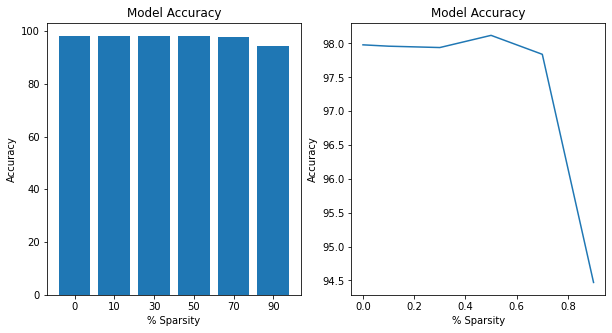

In [ ]:
# Figure Size
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))

# Horizontal Bar Plot
sparsity=[0,10,30,50,70,90]
ax1.bar(list(map(str, sparsity)), acc)

ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('% Sparsity')

sparsity=[0,0.1,0.3,0.5,0.7,0.9]
ax2.plot(sparsity,acc)
ax2.set_title('Model Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('% Sparsity')



(0.0, 0.0005)

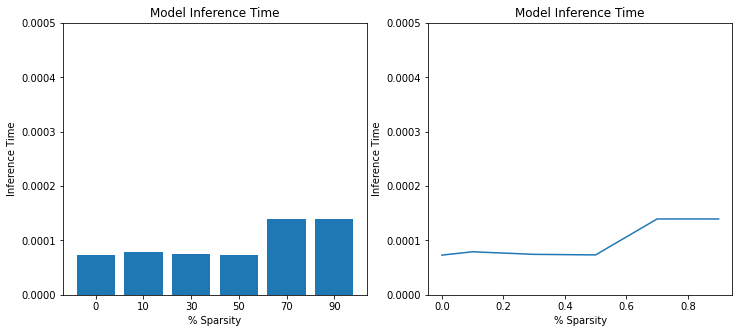

In [ ]:
# Figure Size
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,5))

# Horizontal Bar Plot
sparsity=[0,10,30,50,70,90]
ax1.bar(list(map(str, sparsity)), inf_time)

ax1.set_title('Model Inference Time')
ax1.set_ylabel('Inference Time')
ax1.set_xlabel('% Sparsity')

ax1.set_ylim((0,0.0005))

ax2.plot(sparsity,inf_time)
ax2.set_title('Model Inference Time')
ax2.set_ylabel('Inference Time')
ax2.set_xlabel('% Sparsity')

ax2.set_ylim((0,0.0005))


Text(0.5, 0, '% Sparsity')

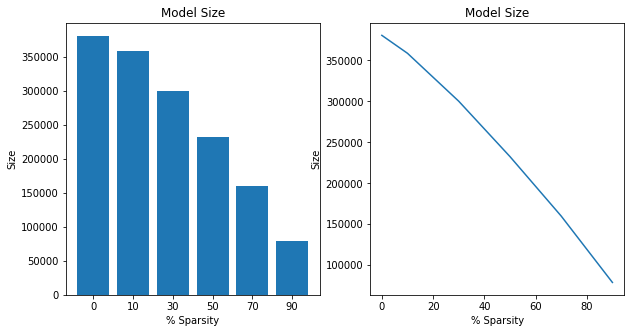

In [ ]:
# Figure Size
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))

# Horizontal Bar Plot
sparsity=[0,10,30,50,70,90]
ax1.bar(list(map(str, sparsity)), size)

ax1.set_title('Model Size')
ax1.set_ylabel('Size')
ax1.set_xlabel('% Sparsity')

ax2.plot(sparsity,size)
ax2.set_title('Model Size')
ax2.set_ylabel('Size')
ax2.set_xlabel('% Sparsity')


# **Part 2**:  Quantization
This part of the lab demonstrates applying quantization to a neural network to reduce size and inference while maintaining a similar accuracy to the original neural network. At a high level, the steps required to quantize and evaluate a model are as follows:

- Build and train the dense baseline
- Apply quantization during conversion to TFLite
- Evaluate the model

There are different quantization techniques, the technique demonstrated in this lab is post-training quantization. The main idea behind quantization is that the weights and activations can be converted to types with reduced precision, such as 16 bit floats or 8 bit integers instead of 32 bit floats which can signficantly reduce model size and inference with minimal accuracy tradeoffs.

TensorFlow Lite is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded, and edge devices.

A TensorFlow Lite model is represented in a special efficient portable format known as FlatBuffers (identified by the .tflite file extension). This provides several advantages over TensorFlow's protocol buffer model format such as reduced size (small code footprint) and faster inference (data is directly accessed without an extra parsing/unpacking step) that enables TensorFlow Lite to execute efficiently on devices with limited compute and memory resources.
You can find more information here: https://www.tensorflow.org/lite/guide

### Load base model
Firstly, let us load the base model we have trained earlier.

In [ ]:
model_to_quantize = tf.keras.models.load_model('trained_base_model.h5')
model_to_quantize.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


### Convert to TFLite and apply quantization
The next step is converting the base model to a TFLite model and applying quantization through the different APIs that TFLite provides. In this example we are using 8-bit quantization, this is done by using the DEFAULT optimizer. The commented codes provide an example of how to apply 16-bit floating point quantization.

In [ ]:
# Passing the Keras model to the TFLite Converter.
converter = tf.lite.TFLiteConverter.from_keras_model(model_to_quantize)
# Setting the deault optimizer
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# To convert to 16-bit floating point for example
# converter.target_spec.supported_types = [tf.float16]
# Convert the model
quantized_tflite_model = converter.convert()

### Save TFLite model and load model into an interpeter
Firstly we save the TFLite model, this will allow us to load it into an interpreter. To perform an inference with a TensorFlow Lite model, you must run it through an interpreter. The TensorFlow Lite interpreter is designed to be lean and fast.
You can find more information on the TFLite interpeter here: https://www.tensorflow.org/lite/guide/inference

In [ ]:
# Save TFLite Model
with open('quantized_tflite_model.tflite', 'wb') as f:
  f.write(quantized_tflite_model)
# Load model into interpeter
interpreter_quant = tf.lite.Interpreter(model_path=str('quantized_tflite_model.tflite'))
interpreter_quant.allocate_tensors()

### Evaluate the model
Finally, we evaluate the quantized model in terms of accuracy, inference time and model size.

In [ ]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter, model_path):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    startTime = time.time()
    interpreter.invoke()
    executionTime = (time.time() - startTime)/len(test_images)

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  model_size = get_gzipped_model_size(model_path)
  # Print
  print('\nModel Accuracy:', accuracy*100, '%')
  print("Model Size: %.2f bytes" % (model_size))
  print("Inference Time is", executionTime, "s")
  return accuracy, model_size, executionTime

evaluate_model(interpreter_quant, 'quantized_tflite_model.tflite')


Model Accuracy: 97.57000000000001 %
Model Size: 81557.00 bytes
Inference Time is 1.0013580322265624e-09 s


(0.9757, 81557, 1.0013580322265624e-09)

### Exercise (0.5 points)

Question 1: Load the base model and apply 16 bit floating point quantization. Use the TFLite interpeter to evaluate your model. **(0.5 points)**

In [ ]:
# INSERT YOUR CODE HERE
model_to_quantize = tf.keras.models.load_model('trained_base_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model_to_quantize)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
fp16_quantized_tflite_model = converter.convert()

with open('fp16_quantized_tflite_model.tflite', 'wb') as f:
  f.write(fp16_quantized_tflite_model)
interpreter_fp16_quant = tf.lite.Interpreter(model_path=str('fp16_quantized_tflite_model.tflite'))
interpreter_fp16_quant.allocate_tensors()

evaluate_model(interpreter_fp16_quant, 'fp16_quantized_tflite_model.tflite')


Model Accuracy: 97.76 %
Model Size: 189952.00 bytes
Inference Time is 1.049041748046875e-09 s


(0.9776, 189952, 1.049041748046875e-09)

# Part 3: Collaborative Optimization



### Exercise
Question 1 (2 points): Using the knowledge from part 1 and part 2, jointly apply pruning and post-training quantization to the base MNIST model.

Try the following combinations and plot 3 graphs (one for each metric of accuracy, model size , and inference time):

- no pruning, no quantization
- no pruning, fp16 quantization
- no pruning, 8-bit quantization

- 10% sparsity, no quantization
- 10% sparsity, fp16 quantization
- 10% sparsity, 8-bit quantization

- 50% sparsity, no quantization
- 50% sparsity, fp16 quantization
- 50% sparsity, 8-bit quantization

- 90% sparsity, no quantization
- 90% sparsity, fp16 quantization
- 90% sparsity, 8-bit quantization

To do this, write a prune_and_quantize function and loop over different sparsities and then append all the results into 3 different arrays (one for each metric).

For example the function definition could look like this:

**def prune_and_quantize(model, target_sparsity, fp16: bool, path_to_save)**

Hint: Below is an example of how you can graph your results using matplotlib
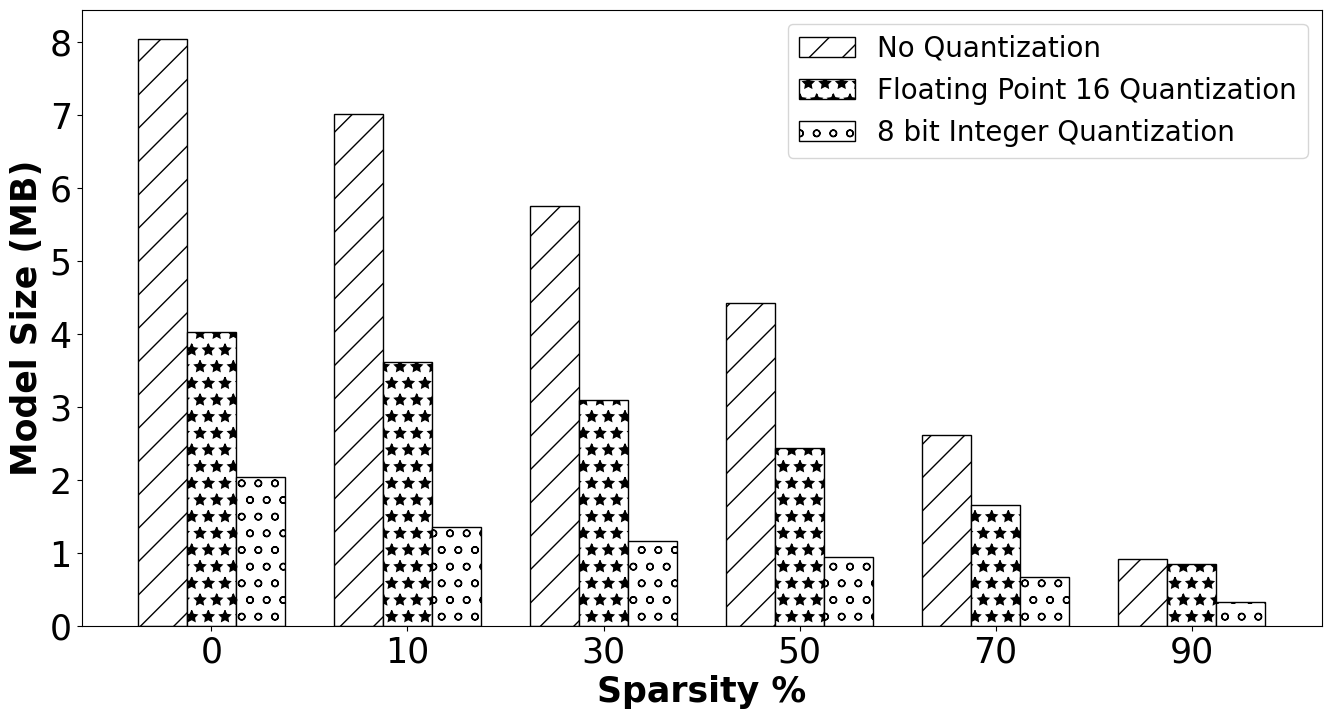

In [ ]:
def prune_and_quantize(model, target_sparsity, path_to_save, fp16=False, BI8=False):

  # Pruning the model with a target sparsity of x%
  prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

  # Define model for pruning.
  pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(target_sparsity, begin_step=0, frequency=100)
  }

  pruned_model = prune_low_magnitude(model, **pruning_params)

  # `prune_low_magnitude` requires a recompile.
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
  pruned_model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  # Fine tune pruned model
  callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
  ]

  pruned_model.fit(train_images, train_labels, epochs=2, validation_split=0.1,
                    callbacks=callbacks)

  # Applying strip pruning
  stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

  # Confirming that pruning was applied correctly
  print_model_weights_sparsity(stripped_pruned_model)

  if fp16:
    converter = tf.lite.TFLiteConverter.from_keras_model(stripped_pruned_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.float16]
    quantized_tflite_model = converter.convert()

    with open(path_to_save, 'wb') as f:
      f.write(quantized_tflite_model)
    interpreter_quant = tf.lite.Interpreter(model_path=str(path_to_save))
    interpreter_quant.allocate_tensors()

    test_acc,size,executionTime = evaluate_model(interpreter_quant, path_to_save)

  elif BI8:
    # Passing the Keras model to the TFLite Converter.
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    # Setting the deault optimizer
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    # Convert the model
    quantized_tflite_model = converter.convert()

    # Save TFLite Model
    with open(path_to_save, 'wb') as f:
      f.write(quantized_tflite_model)
    # Load model into interpeter
    interpreter_quant = tf.lite.Interpreter(model_path=str(path_to_save))
    interpreter_quant.allocate_tensors()

    test_acc,size,executionTime = evaluate_model(interpreter_quant, path_to_save)

  else:
    # save model
    stripped_pruned_model.save(path_to_save)

    # Evaluate prediction accuracy of pruned model
    test_loss, test_acc = pruned_model.evaluate(test_images,  test_labels, verbose=0)
    test_acc=test_acc*100

    # Evaluate Inference Time of pruned model
    startTime = time.time()
    prediction = pruned_model.predict(test_images)
    executionTime = (time.time() - startTime)/len(test_images)

    # Evaluate size of pruned model
    size = get_gzipped_model_size(path_to_save)

  return test_acc, executionTime, size

In [ ]:
# Base model
base_model = tf.keras.models.load_model('trained_base_model.h5')

# Sparsity list
spars_list = [0.0,0.1,0.5,0.9]

# No quantization
acc_0Q=[]
exec_time_0Q=[]
size_0Q=[]

for spar in spars_list:
  acc,exec_time,size=prune_and_quantize(base_model, spar, '{}P_0Q.h5'.format(spar*100))
  acc_0Q.append(acc)
  exec_time_0Q.append(exec_time)
  size_0Q.append(size)

# 8-bit quantization
acc_8Q=[]
exec_time_8Q=[]
size_8Q=[]

for spar in spars_list:
  acc,exec_time,size=prune_and_quantize(base_model, spar, '{}P_8Q_tflite_model.tflite'.format(spar*100), BI8=True)
  acc_8Q.append(acc)
  exec_time_8Q.append(exec_time)
  size_8Q.append(size)

# fp16 quantization
acc_16Q=[]
exec_time_16Q=[]
size_16Q=[]

for spar in spars_list:
  acc,exec_time,size=prune_and_quantize(base_model, spar, '{}P_16Q_tflite_model.tflite'.format(spar*100), fp16=True)
  acc_16Q.append(acc)
  exec_time_16Q.append(exec_time)
  size_16Q.append(size)


Epoch 1/2
1688/1688 [==============================] - 11s 6ms/step - loss: 0.0685 - accuracy: 0.9776 - val_loss: 0.0761 - val_accuracy: 0.9807
Epoch 2/2
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0624 - accuracy: 0.9797 - val_loss: 0.0728 - val_accuracy: 0.9797


dense/kernel:0: 0.00% sparsity  (0/100352)
dense_1/kernel:0: 0.00% sparsity  (0/1280)
313/313 [==============================] - 1s 2ms/step
Epoch 1/2
1688/1688 [==============================] - 12s 6ms/step - loss: 0.0543 - accuracy: 0.9829 - val_loss: 0.0716 - val_accuracy: 0.9795
Epoch 2/2
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0485 - accuracy: 0.9839 - val_loss: 0.0693 - val_accuracy: 0.9813


dense/kernel:0: 10.00% sparsity  (10035/100352)
dense_1/kernel:0: 10.00% sparsity  (128/1280)
313/313 [==============================] - 1s 2ms/step
Epoch 1/2
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0543 - accuracy: 0.9818 - val_loss: 0.0670 - val_accuracy: 0.9812
Epoch 2/2
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0421 - accuracy: 0.9861 - val_loss: 0.0681 - val_accuracy: 0.9820


dense/kernel:0: 50.00% sparsity  (50176/100352)
dense_1/kernel:0: 50.00% sparsity  (640/1280)
313/313 [==============================] - 1s 2ms/step
Epoch 1/2
1688/1688 [==============================] - 13s 7ms/step - loss: 0.5669 - accuracy: 0.8155 - val_loss: 0.2151 - val_accuracy: 0.9435
Epoch 2/2
1688/1688 [==============================] - 15s 9ms/step - loss: 0.3364 - accuracy: 0.8973 - val_loss: 0.1716 - val_accuracy: 0.9530


dense/kernel:0: 90.00% sparsity  (90317/100352)
dense_1/kernel:0: 90.00% sparsity  (1152/1280)
313/313 [==============================] - 1s 4ms/step
Epoch 1/2
1688/1688 [==============================] - 14s 7ms/step - loss: 0.1634 - accuracy: 0.9513 - val_loss: 0.0866 - val_accuracy: 0.9755
Epoch 2/2
1688/1688 [==============================] - 10s 6ms/step - loss: 0.0958 - accuracy: 0.9703 - val_loss: 0.0780 - val_accuracy: 0.9797
dense/kernel:0: 11.50% sparsity  (11537/100352)
dense_1/kernel:0: 0.00% sparsity  (0/1280)



Model Accuracy: 97.75 %
Model Size: 63184.00 bytes
Inference Time is 1.3828277587890624e-09 s
Epoch 1/2
1688/1688 [==============================] - 10s 5ms/step - loss: 0.0781 - accuracy: 0.9750 - val_loss: 0.0694 - val_accuracy: 0.9825
Epoch 2/2
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0633 - accuracy: 0.9798 - val_loss: 0.0696 - val_accuracy: 0.9810
dense/kernel:0: 11.14% sparsity  (11178/100352)
dense_1/kernel:0: 10.00% sparsity  (128/1280)



Model Accuracy: 98.09 %
Model Size: 67381.00 bytes
Inference Time is 1.0013580322265624e-09 s
Epoch 1/2
1688/1688 [==============================] - 10s 5ms/step - loss: 0.0522 - accuracy: 0.9829 - val_loss: 0.0634 - val_accuracy: 0.9823
Epoch 2/2
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0438 - accuracy: 0.9861 - val_loss: 0.0617 - val_accuracy: 0.9852
dense/kernel:0: 50.00% sparsity  (50176/100352)
dense_1/kernel:0: 50.00% sparsity  (640/1280)



Model Accuracy: 98.16 %
Model Size: 57807.00 bytes
Inference Time is 9.775161743164063e-10 s
Epoch 1/2
1688/1688 [==============================] - 10s 5ms/step - loss: 0.2675 - accuracy: 0.9156 - val_loss: 0.1482 - val_accuracy: 0.9612
Epoch 2/2
1688/1688 [==============================] - 7s 4ms/step - loss: 0.2536 - accuracy: 0.9206 - val_loss: 0.1399 - val_accuracy: 0.9633
dense/kernel:0: 90.00% sparsity  (90317/100352)
dense_1/kernel:0: 90.00% sparsity  (1152/1280)



Model Accuracy: 95.54 %
Model Size: 20315.00 bytes
Inference Time is 1.0013580322265624e-09 s
Epoch 1/2
1688/1688 [==============================] - 10s 5ms/step - loss: 0.1423 - accuracy: 0.9566 - val_loss: 0.0873 - val_accuracy: 0.9772
Epoch 2/2
1688/1688 [==============================] - 14s 9ms/step - loss: 0.0861 - accuracy: 0.9731 - val_loss: 0.0794 - val_accuracy: 0.9788
dense/kernel:0: 11.74% sparsity  (11783/100352)
dense_1/kernel:0: 0.00% sparsity  (0/1280)

Model Accuracy: 97.63 %
Model Size: 179602.00 bytes
Inference Time is 1.049041748046875e-09 s
Epoch 1/2
1688/1688 [==============================] - 14s 7ms/step - loss: 0.0705 - accuracy: 0.9772 - val_loss: 0.0715 - val_accuracy: 0.9807
Epoch 2/2
1688/1688 [==============================] - 10s 6ms/step - loss: 0.0586 - accuracy: 0.9806 - val_loss: 0.0696 - val_accuracy: 0.9812
dense/kernel:0: 11.36% sparsity  (11400/100352)
dense_1/kernel:0: 10.00% sparsity  (128/1280)

Model Accuracy: 97.92999999999999 %
Model Size: 

In [ ]:
acc_8Q=[i * 100 for i in acc_8Q]
acc_16Q=[i * 100 for i in acc_16Q]

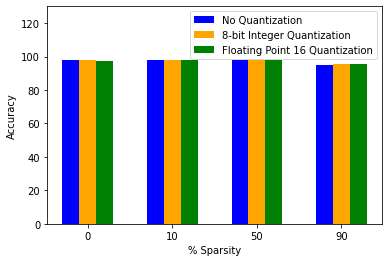

In [ ]:
# Accuracy plot

# create data
x = np.arange(4)
width = 0.2

# plot data in grouped manner of bar type
plt.bar(x-0.2, acc_0Q, width, color='blue')
plt.bar(x, acc_8Q, width, color='orange')
plt.bar(x+0.2, acc_16Q, width, color='green')
plt.xticks(x, ['0','10','50','90'])
plt.xlabel("% Sparsity")
plt.ylabel("Accuracy")
plt.legend(["No Quantization", "8-bit Integer Quantization", "Floating Point 16 Quantization"])
plt.ylim((0,130))
plt.show()

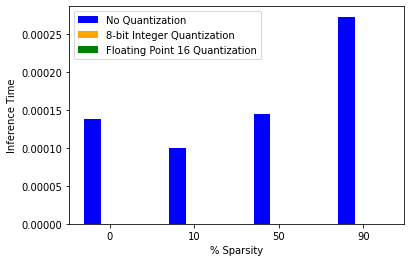

In [ ]:
# Inference time plot

# create data
x = np.arange(4)
width = 0.2

# plot data in grouped manner of bar type
plt.bar(x-0.2, exec_time_0Q, width, color='blue')
plt.bar(x, exec_time_8Q, width, color='orange')
plt.bar(x+0.2, exec_time_16Q, width, color='green')
plt.xticks(x, ['0','10','50','90'])
plt.xlabel("% Sparsity")
plt.ylabel("Inference Time")
plt.legend(["No Quantization", "8-bit Integer Quantization", "Floating Point 16 Quantization"])

plt.show()

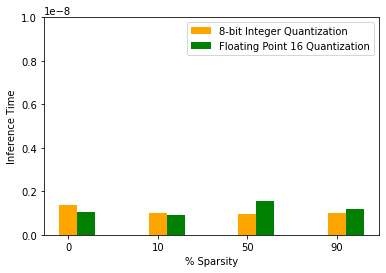

In [ ]:
# Inference time plot

# create data
x = np.arange(4)
width = 0.2

# plot data in grouped manner of bar type
plt.bar(x, exec_time_8Q, width, color='orange')
plt.bar(x+0.2, exec_time_16Q, width, color='green')
plt.xticks(x, ['0','10','50','90'])
plt.xlabel("% Sparsity")
plt.ylabel("Inference Time")
plt.legend(["8-bit Integer Quantization", "Floating Point 16 Quantization"])
plt.ylim((0,1e-8))
plt.show()

The 8-bit integer and floating point 16 quantization are just much faster than with no quantization.

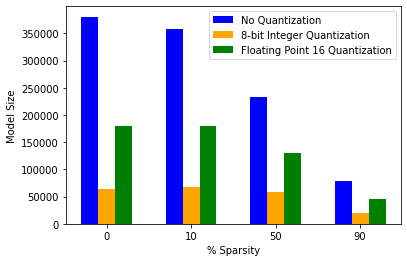

In [ ]:
# Size plot

# create data
x = np.arange(4)
width = 0.2

# plot data in grouped manner of bar type
plt.bar(x-0.2, size_0Q, width, color='blue')
plt.bar(x, size_8Q, width, color='orange')
plt.bar(x+0.2, size_16Q, width, color='green')
plt.xticks(x, ['0','10','50','90'])
plt.xlabel("% Sparsity")
plt.ylabel("Model Size")
plt.legend(["No Quantization", "8-bit Integer Quantization", "Floating Point 16 Quantization"])

plt.show()

Question-2 (1 point) Redo question 1 above (using the funnction that you wrote) but this time using the CNN model that you proposed in Lab-1 Q4 as the base model. Discuss the trade-offs obtained between accuracy and model size as a function of pruning level and quantization. This time, also plot the histrogram of weights (a particular layer or all over them combined) for at least 2 different pruning levels (sample code for this is shown under visualize pruning. Does the histogram of pruned weights give any insights on the accuracy observed?

In [ ]:
# CNN base model
# Rebuilding the model with 2048 neurons in the first Dense layer instead of 128
new_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

# Change the learning rate to 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Recomple and retrain the model
new_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

new_model.fit(train_images, train_labels, epochs=5,
                    validation_data=(test_images, test_labels))


Epoch 1/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1926 - accuracy: 0.9415 - val_loss: 0.0976 - val_accuracy: 0.9695
Epoch 2/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0856 - accuracy: 0.9733 - val_loss: 0.0937 - val_accuracy: 0.9717
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0647 - accuracy: 0.9799 - val_loss: 0.0704 - val_accuracy: 0.9793
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0501 - accuracy: 0.9842 - val_loss: 0.0693 - val_accuracy: 0.9786
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0409 - accuracy: 0.9864 - val_loss: 0.0780 - val_accuracy: 0.9776


In [ ]:
# INSERT YOUR CODE HERE

# Sparsity list
spars_list = [0.0,0.1,0.5,0.9]

# No quantization
acc_0Q=[]
exec_time_0Q=[]
size_0Q=[]

for spar in spars_list:
  acc,exec_time,size=prune_and_quantize(new_model, spar, '{}P_0Q.h5'.format(spar*100))
  acc_0Q.append(acc)
  exec_time_0Q.append(exec_time)
  size_0Q.append(size)

# 8-bit quantization
acc_8Q=[]
exec_time_8Q=[]
size_8Q=[]

for spar in spars_list:
  acc,exec_time,size=prune_and_quantize(new_model, spar, '{}P_8Q_tflite_model.tflite'.format(spar*100), BI8=True)
  acc_8Q.append(acc)
  exec_time_8Q.append(exec_time)
  size_8Q.append(size)

# fp16 quantization
acc_16Q=[]
exec_time_16Q=[]
size_16Q=[]

for spar in spars_list:
  acc,exec_time,size=prune_and_quantize(new_model, spar, '{}P_16Q_tflite_model.tflite'.format(spar*100), fp16=True)
  acc_16Q.append(acc)
  exec_time_16Q.append(exec_time)
  size_16Q.append(size)

Epoch 1/2
1688/1688 [==============================] - 10s 5ms/step - loss: 0.0425 - accuracy: 0.9871 - val_loss: 0.0387 - val_accuracy: 0.9893
Epoch 2/2
1688/1688 [==============================] - 8s 4ms/step - loss: 0.0285 - accuracy: 0.9908 - val_loss: 0.0348 - val_accuracy: 0.9902


dense_6/kernel:0: 0.00% sparsity  (0/1605632)
dense_7/kernel:0: 0.00% sparsity  (0/20480)
313/313 [==============================] - 1s 2ms/step
Epoch 1/2
1688/1688 [==============================] - 10s 5ms/step - loss: 0.0313 - accuracy: 0.9911 - val_loss: 0.0500 - val_accuracy: 0.9872
Epoch 2/2
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0252 - accuracy: 0.9924 - val_loss: 0.0412 - val_accuracy: 0.9900


dense_6/kernel:0: 10.00% sparsity  (160563/1605632)
dense_7/kernel:0: 10.00% sparsity  (2048/20480)
313/313 [==============================] - 1s 2ms/step
Epoch 1/2
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0170 - accuracy: 0.9946 - val_loss: 0.0415 - val_accuracy: 0.9905
Epoch 2/2
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0110 - accuracy: 0.9964 - val_loss: 0.0439 - val_accuracy: 0.9912


dense_6/kernel:0: 50.00% sparsity  (802816/1605632)
dense_7/kernel:0: 50.00% sparsity  (10240/20480)
313/313 [==============================] - 1s 2ms/step
Epoch 1/2
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0484 - accuracy: 0.9851 - val_loss: 0.0354 - val_accuracy: 0.9902
Epoch 2/2
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0238 - accuracy: 0.9929 - val_loss: 0.0334 - val_accuracy: 0.9900


dense_6/kernel:0: 90.00% sparsity  (1445069/1605632)
dense_7/kernel:0: 90.00% sparsity  (18432/20480)
313/313 [==============================] - 1s 2ms/step
Epoch 1/2
1688/1688 [==============================] - 50s 5ms/step - loss: 0.0555 - accuracy: 0.9831 - val_loss: 0.0488 - val_accuracy: 0.9853
Epoch 2/2
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0318 - accuracy: 0.9900 - val_loss: 0.0441 - val_accuracy: 0.9885
dense_6/kernel:0: 25.84% sparsity  (414867/1605632)
dense_7/kernel:0: 8.54% sparsity  (1749/20480)

Model Accuracy: 97.94 %
Model Size: 815681.00 bytes
Inference Time is 1.1539459228515625e-08 s
Epoch 1/2
1688/1688 [==============================] - 12s 6ms/step - loss: 0.0386 - accuracy: 0.9884 - val_loss: 0.0771 - val_accuracy: 0.9832
Epoch 2/2
1688/1688 [==============================] - 10s 6ms/step - loss: 0.0269 - accuracy: 0.9914 - val_loss: 0.0628 - val_accuracy: 0.9877
dense_6/kernel:0: 24.28% sparsity  (389801/1605632)
dense_7/kernel:0: 10.

In [ ]:
acc_8Q=[i * 100 for i in acc_8Q]
acc_16Q=[i * 100 for i in acc_16Q]

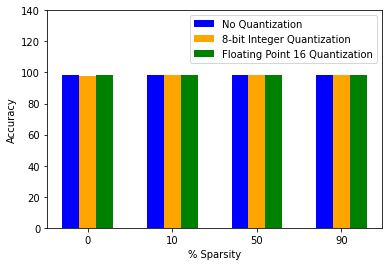

In [ ]:
# Accuracy plot

# create data
x = np.arange(4)
width = 0.2

# plot data in grouped manner of bar type
plt.bar(x-0.2, acc_0Q, width, color='blue')
plt.bar(x, acc_8Q, width, color='orange')
plt.bar(x+0.2, acc_16Q, width, color='green')
plt.xticks(x, ['0','10','50','90'])
plt.xlabel("% Sparsity")
plt.ylabel("Accuracy")
plt.legend(["No Quantization", "8-bit Integer Quantization", "Floating Point 16 Quantization"])
plt.ylim((0,140))
plt.show()

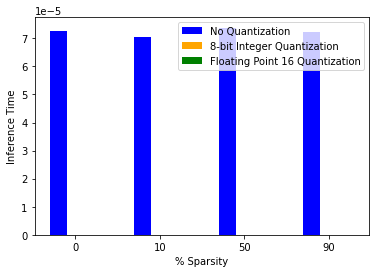

In [ ]:
# Inference time plot

# create data
x = np.arange(4)
width = 0.2

# plot data in grouped manner of bar type
plt.bar(x-0.2, exec_time_0Q, width, color='blue')
plt.bar(x, exec_time_8Q, width, color='orange')
plt.bar(x+0.2, exec_time_16Q, width, color='green')
plt.xticks(x, ['0','10','50','90'])
plt.xlabel("% Sparsity")
plt.ylabel("Inference Time")
plt.legend(["No Quantization", "8-bit Integer Quantization", "Floating Point 16 Quantization"])

plt.show()

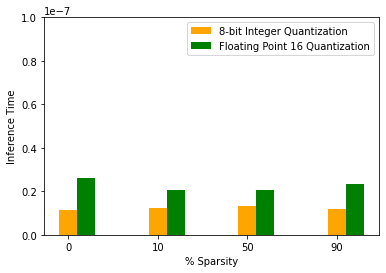

In [ ]:
# Inference time plot

# create data
x = np.arange(4)
width = 0.2

# plot data in grouped manner of bar type
plt.bar(x, exec_time_8Q, width, color='orange')
plt.bar(x+0.2, exec_time_16Q, width, color='green')
plt.xticks(x, ['0','10','50','90'])
plt.xlabel("% Sparsity")
plt.ylabel("Inference Time")
plt.legend(["8-bit Integer Quantization", "Floating Point 16 Quantization"])
plt.ylim((0,1e-7))
plt.show()

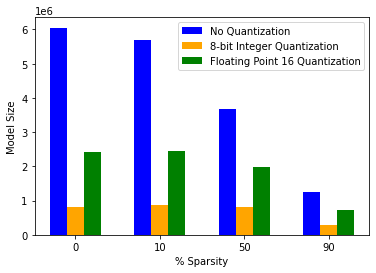

In [ ]:
# Size plot

# create data
x = np.arange(4)
width = 0.2

# plot data in grouped manner of bar type
plt.bar(x-0.2, size_0Q, width, color='blue')
plt.bar(x, size_8Q, width, color='orange')
plt.bar(x+0.2, size_16Q, width, color='green')
plt.xticks(x, ['0','10','50','90'])
plt.xlabel("% Sparsity")
plt.ylabel("Model Size")
plt.legend(["No Quantization", "8-bit Integer Quantization", "Floating Point 16 Quantization"])

plt.show()

Increasing the pruning level did not cause a noticeable change in accuracy until 90% was used even then the original base model only had a small change in accuracy and the CNN model had even less of a change. Quantization did not affect the accuracy. Model size was affected by both pruining and quantization. The more pruning that was done caused the model to be smaller but quantization had a bigger affect at decreasing the size of the model at all levels of pruning. 8-bit integer quantization had the smallest model sizes.

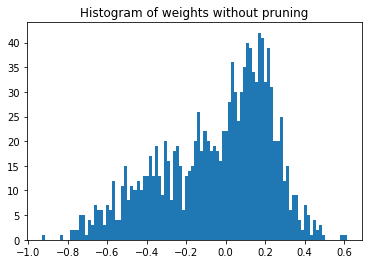

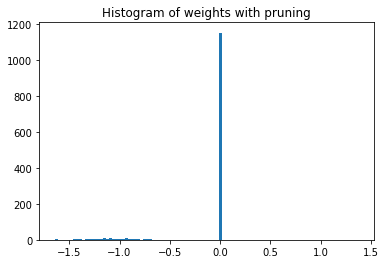

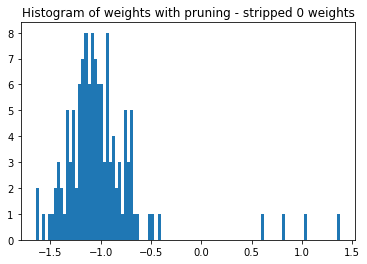

In [ ]:
## Plotting Pruning Histograms for 90% sparsity
model = tf.keras.models.load_model('trained_base_model.h5')
a = model.layers[3].weights
b = pruned_model_90.layers[3].weights

k = a[0].numpy().flatten()
plt.hist(k, bins = 100)
plt.title("Histogram of weights without pruning")
plt.show()

j = b[0].numpy().flatten()
plt.hist(j, bins = 100)
plt.title("Histogram of weights with pruning")
plt.show()

l = j[j != 0]
plt.hist(l, bins = 100)
plt.title("Histogram of weights with pruning - stripped 0 weights")
plt.show()


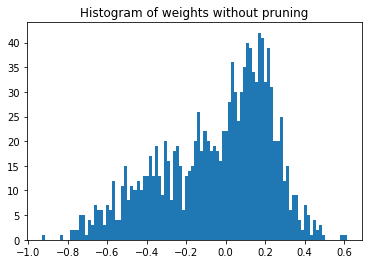

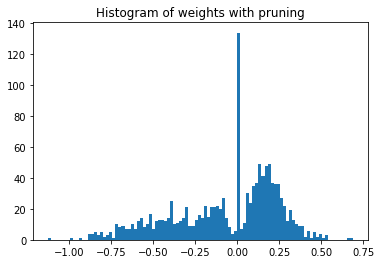

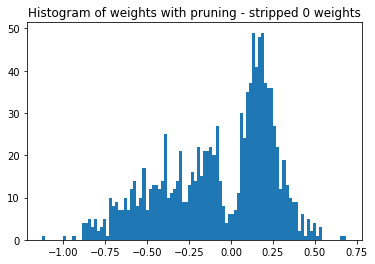

In [ ]:
## Plotting Pruning Histograms for 10% sparsity
model = tf.keras.models.load_model('trained_base_model.h5')
a = model.layers[3].weights
b = pruned_model_10.layers[3].weights

k = a[0].numpy().flatten()
plt.hist(k, bins = 100)
plt.title("Histogram of weights without pruning")
plt.show()

j = b[0].numpy().flatten()
plt.hist(j, bins = 100)
plt.title("Histogram of weights with pruning")
plt.show()

l = j[j != 0]
plt.hist(l, bins = 100)
plt.title("Histogram of weights with pruning - stripped 0 weights")
plt.show()

The accuracy with 10% pruning was higher than 90% pruning. The histogram of pruned weights shows insight into the acuracy observed because more weights and a more even distribution about 0 was seen with 10% pruning while there were fewer weights for the 90% pruning and they were mostly all negative. More weights for the 10% pruning also provides insight into why this model size was larger.  

# Bonus: Visualize Pruning
In this section we will graph a small subset of the weights at different levels of pruning. The graphs clearly show how different sparsity levels affect the number of zero weights, it also shows that our pruning is unstructured.

We also provide histograms of the weights before and after pruning.

Note: Make sure you have saved the tflite files with the same names used below, alternatively you can change the model path with your correct file name. The first visualization relies on files collected from the exercise in PART 3!

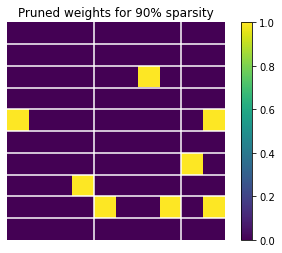

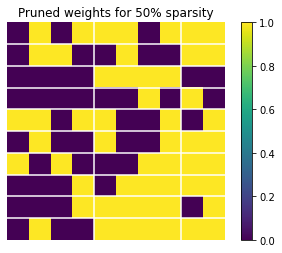

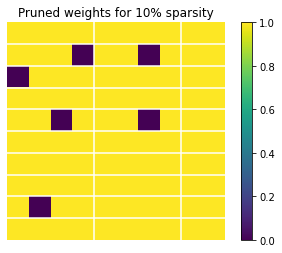

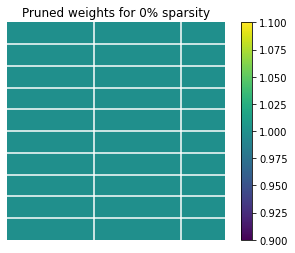

In [ ]:
def get_tensor_data(model_path):
  # Load tflite file with the created pruned model
  interpreter = tf.lite.Interpreter(model_path=model_path)
  interpreter.allocate_tensors()

  details = interpreter.get_tensor_details()

  # Weights of the dense layer that has been pruned.
  tensor_name = 'sequential/dense_1/MatMul'
  detail = [x for x in details if tensor_name in x["name"]]

  # We need the first layer.
  tensor_data = interpreter.tensor(detail[0]["index"])()
  return tensor_data

# The value 10 is chosen for convenience.
width = height = 10


def plot_separation_lines(height, width):

    block_size = [1, 4]

    # Add separation lines to the figure.
    num_hlines = int((height - 1) / block_size[0])
    num_vlines = int((width - 1) / block_size[1])
    line_y_pos = [y * block_size[0] for y in range(1, num_hlines + 1)]
    line_x_pos = [x * block_size[1] for x in range(1, num_vlines + 1)]

    for y_pos in line_y_pos:
        plt.plot([-0.5, width], [y_pos - 0.5 , y_pos - 0.5], color='w')

    for x_pos in line_x_pos:
        plt.plot([x_pos - 0.5, x_pos - 0.5], [-0.5, height], color='w')

def plot_weights_graph(tensor_data, sparsity):
  weights_to_display = tf.reshape(tensor_data, [tensor_data.shape[0],tf.reduce_prod(tensor_data.shape[1:])])
  weights_to_display = weights_to_display[0:width, 0:height]

  val_ones = np.ones([height, width])
  val_zeros = np.zeros([height, width])
  subset_values_to_display = np.where(abs(weights_to_display) > 0, val_ones, val_zeros)

  plot_separation_lines(height, width)

  plt.axis('off')
  plt.imshow(subset_values_to_display)
  plt.colorbar()
  plt.title("Pruned weights for {0}% sparsity".format(sparsity))
  plt.show()

## USE YOUR MODEL PATH
plot_weights_graph(get_tensor_data('pruned_0.9_fp16_quantized_tflite_model.tflite'), 90)
plot_weights_graph(get_tensor_data('pruned_0.5_fp16_quantized_tflite_model.tflite'), 50)
plot_weights_graph(get_tensor_data('pruned_0.1_fp16_quantized_tflite_model.tflite'), 10)
plot_weights_graph(get_tensor_data('pruned_0_fp16_quantized_tflite_model.tflite'), 0)

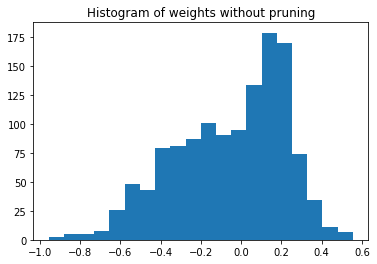

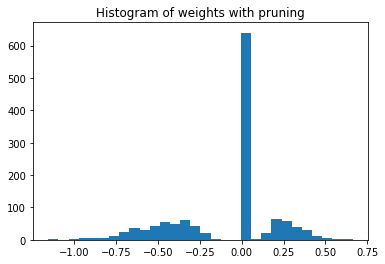

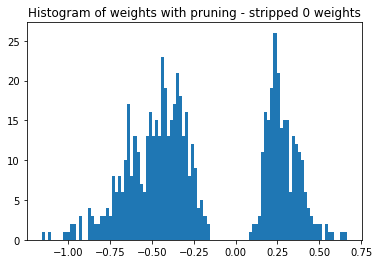

In [ ]:
## Plotting Pruning Histograms
model = tf.keras.models.load_model('trained_base_model.h5')
a = model.layers[3].weights
b = pruned_model.layers[3].weights

k = a[0].numpy().flatten()
plt.hist(k, bins = 100)
plt.title("Histogram of weights without pruning")
plt.show()

j = b[0].numpy().flatten()
plt.hist(j, bins = 100)
plt.title("Histogram of weights with pruning")
plt.show()

l = j[j != 0]
plt.hist(l, bins = 100)
plt.title("Histogram of weights with pruning - stripped 0 weights")
plt.show()